# Data processing

## Load data

In [1277]:
from utils import *

import matplotlib.pyplot as plt
import seaborn as sb
from copy import deepcopy

%matplotlib inline

account_df = read_to_df("account.csv")
card_test_df = read_to_df("card_test.csv")
card_train_df = read_to_df("card_train.csv")
client_df = read_to_df("client.csv")
disp_df = read_to_df("disp.csv")
district_df = read_to_df("district.csv")
loan_test_df = read_to_df("loan_test.csv")
loan_train_df = read_to_df("loan_train.csv")
trans_test_df = read_to_df("trans_test.csv")
trans_train_df = read_to_df("trans_train.csv")

C:\Users\skelo\AppData\Local\Temp/ipykernel_12460/160468940.py:18: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  trans_train_df = read_to_df("trans_train.csv")


## Process data

### Process account data

In [1278]:
avg_transactions_per_week = 3
avg_weeks_per_month = (365.25 / 7 / 12)

account_df['frequency'] = account_df['frequency'].apply(lambda x: 1 if x == 'monthly issuance' else avg_weeks_per_month if x == 'weekly issuance' else (365.25 / 7 / 12) * avg_transactions_per_week)
account_df["date"] = account_df["date"].apply(lambda x: read_date(x))
account_df.rename(columns={"date": "creation_date", "frequency": "issuance_frequency_per_month"}, inplace=True)

account_df.head()

,account_id,district_id,issuance_frequency_per_month,creation_date
0,576,55,1.0,1993-01-01
1,3818,74,1.0,1993-01-01
2,704,55,1.0,1993-01-01
3,2378,16,1.0,1993-01-01
4,2632,24,1.0,1993-01-02


### Process client data

In [1279]:
client_df["sex"] = client_df["birth_number"].apply(lambda x: 0 if int(str(x)[2:4]) > 50 else 1)
client_df["age"] = client_df["birth_number"].apply(lambda x: calculate_age(read_date(x)))

client_df.drop("birth_number", inplace=True, axis=1)

client_df.head()

,client_id,district_id,sex,age
0,1,18,0,28
1,2,1,1,53
2,3,1,0,58
3,4,5,1,42
4,5,5,0,38


### Process disposition data

In [1280]:
disp_df.rename(columns={"type": "is_owner"}, inplace=True)
disp_df["is_owner"].replace({"OWNER": True, "DISPONENT": False}, inplace=True)

# Count number clients per account
client_count_df = disp_df.groupby("account_id", as_index=False, group_keys=False).agg(client_count=("is_owner", "count"))

disp_df = disp_df.merge(client_count_df, on="account_id")
disp_df = disp_df[disp_df["is_owner"] == True] 
disp_df.drop("is_owner", axis=1, inplace=True)

disp_df.head()

,disp_id,client_id,account_id,client_count
0,1,1,1,1
1,2,2,2,2
3,4,4,3,2
5,6,6,4,1
6,7,7,5,1


### Process transaction data

In [1281]:
dataframes = [trans_train_df, trans_test_df]

for i in range(len(dataframes)):
    dataframes[i]["operation"].replace(
        {
            "credit in cash": 1,
            "collection from another bank": 2,
            "withdrawal in cash": 3,
            "remittance to another bank": 4,
            "credit card withdrawal": 5,
            "interest credited": 6
        },
        inplace=True
    )

    # Convert "withdrawal in cash" to "withdrawal" in type column
    dataframes[i].loc[dataframes[i]["type"] == "withdrawal in cash", "type"] = "withdrawal"

    # Withdrawal amounts should be negative
    dataframes[i].loc[dataframes[i]["type"] == "withdrawal", "amount"] *= -1

    dataframes[i]["date"] = dataframes[i]["date"].apply(lambda x: read_date(x))
    dataframes[i].rename(columns={"date": "transaction_date"}, inplace=True)

    dataframes[i].drop(["k_symbol", "bank", "account"], axis=1, inplace=True)

trans_train_df, trans_test_df = dataframes

trans_train_df.head()

,trans_id,account_id,transaction_date,type,operation,amount,balance
0,1548749,5270,1993-01-13,credit,1.0,800.0,800.0
1,1548750,5270,1993-01-14,credit,2.0,44749.0,45549.0
2,3393738,11265,1993-01-14,credit,1.0,1000.0,1000.0
3,3122924,10364,1993-01-17,credit,1.0,1100.0,1100.0
4,1121963,3834,1993-01-19,credit,1.0,700.0,700.0


### Process card data

In [1282]:
dataframes = [card_train_df, card_test_df]

for i in range(len(dataframes)):
    dataframes[i]["type"].replace({"classic": 1, "junior": 2, "gold": 3}, inplace=True)
    dataframes[i]["issued"] = dataframes[i]["issued"].apply(lambda x: read_date(x))

card_train_df, card_test_df = dataframes

card_train_df.head()

,card_id,disp_id,type,issued
0,1005,9285,1,1993-11-07
1,104,588,1,1994-01-19
2,747,4915,1,1994-02-05
3,70,439,1,1994-02-08
4,577,3687,1,1994-02-15


### Process demographic data

In [1283]:

district_df.replace("?", np.NaN, inplace=True)

district_df["unemploymant rate '95"].fillna(district_df["unemploymant rate '95"].median(), inplace=True)
district_df["no. of commited crimes '95"].fillna(district_df["no. of commited crimes '95"].median(), inplace=True)

### Process loan data

In [1284]:
loan_dfs = [loan_train_df, loan_test_df]

for i in range(len(loan_dfs)):
    loan_dfs[i]["date"] = loan_dfs[i]["date"].apply(lambda x: read_date(x))
    loan_dfs[i].rename(columns={"date": "loan_date", "amount": "loan_amount"}, inplace=True)

## Generate feature from transaction data

In [1285]:
# transactions = (trans_train_df, trans_test_df)
# account_features = [1, 2]

# for i in range(len(transactions)):
#     # Sorting transactions by date to figure out the most recent balance
#     account_features[i] = transactions[i].sort_values(by="date", axis=0, ascending=False)
#     account_features[i].drop_duplicates(subset='account_id', keep='first', inplace=True)

#     account_features[i].drop(account_features[i].columns.difference(['account_id', 'balance']), axis=1, inplace=True)
#     account_features[i].rename(columns={'balance': 'final_amount'}, inplace=True)

# account_features[0]

## Merge data

In [1286]:
loan_dfs = [loan_train_df, loan_test_df]
trans_dfs = (trans_train_df, trans_test_df)
cards_dfs = (card_train_df, card_test_df)

for i in range(len(loan_dfs)):
    # Merge with dispositions
    loan_dfs[i] = loan_dfs[i].merge(disp_df, on="account_id", how="left")

    # Merge with accounts
    loan_dfs[i] = loan_dfs[i].merge(account_df, on="account_id")

    # Merge with clients
    loan_dfs[i] = loan_dfs[i].merge(client_df, on="client_id", suffixes=["_account", "_client"])

    # Merge with districts
    # loan_dfs[i] = loan_dfs[i].merge(district_df, left_on="district_id_client", right_on="code")

    # Merge with cards
    loan_dfs[i] = loan_dfs[i].merge(cards_dfs[i], on="disp_id", how="left")

    # Merge with transactions
    loan_dfs[i] = loan_dfs[i].merge(trans_dfs[i], on="account_id", suffixes=["_card", "_transaction"])

loan_train_df, loan_test_df = loan_dfs

## Dropping features

- All cards can be dropped as there are only 11 out of the total 328 loans making it very hard or impossible to fill in missing values.
- IDs are no longer needed

In [1287]:
loan_dfs = [loan_train_df, loan_test_df]

for i in range(len(loan_dfs)):
    loan_dfs[i].drop(["card_id", "type_card", "issued"], axis=1, inplace=True)
    loan_dfs[i].drop(["disp_id", "account_id", "client_id"], axis=1, inplace=True)
    loan_dfs[i].drop(["district_id_account", "district_id_client"], axis=1, inplace=True)
    loan_dfs[i].drop(["trans_id"], axis=1, inplace=True)

loan_test_df

,loan_id,loan_date,loan_amount,duration,payments,status,client_count,issuance_frequency_per_month,creation_date,sex,age,transaction_date,type_transaction,operation,amount,balance
0,5895,1997-01-03,93960,60,1566,NaN,1,1.0,1995-10-09,1,36,1995-10-09,credit,1.0,800.0,800.0
1,5895,1997-01-03,93960,60,1566,NaN,1,1.0,1995-10-09,1,36,1995-11-07,credit,1.0,24425.0,25225.0
2,5895,1997-01-03,93960,60,1566,NaN,1,1.0,1995-10-09,1,36,1995-11-08,credit,1.0,500.0,25725.0
3,5895,1997-01-03,93960,60,1566,NaN,1,1.0,1995-10-09,1,36,1995-11-30,credit,NaN,82.2,25807.2
4,5895,1997-01-03,93960,60,1566,NaN,1,1.0,1995-10-09,1,36,1995-12-07,credit,1.0,36637.5,62444.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30195,6748,1998-12-08,240900,60,4015,NaN,1,1.0,1997-06-23,0,49,1998-11-15,withdrawal,3.0,-1800.0,28535.7
30196,6748,1998-12-08,240900,60,4015,NaN,1,1.0,1997-06-23,0,49,1998-11-30,credit,NaN,105.8,28747.4
30197,6748,1998-12-08,240900,60,4015,NaN,1,1.0,1997-06-23,0,49,1998-11-30,withdrawal,3.0,-14.6,28732.8
30198,6748,1998-12-08,240900,60,4015,NaN,1,1.0,1997-06-23,0,49,1998-11-30,credit,NaN,105.8,28641.6


## Aggregate data 

In [1288]:
loan_dfs = [loan_train_df, loan_test_df]

for i in range(len(loan_dfs)):
    aggregated_columns = ("transaction_date", "operation", "amount", "balance", "type_transaction")
    columns = [x for x in loan_dfs[i].columns.to_list() if x not in aggregated_columns]

    df = loan_dfs[i].groupby(columns, as_index=False, group_keys=False, dropna=False).agg({
        "balance": ["min"],
        "transaction_date": ["max"]
    })

    df.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in df.columns]

    # Account age at time of loan in days
    df["account_age"] = (df['loan_date'] - df['creation_date']).dt.days

    # Number of days since last transaction
    df["days_since_last_transaction"] = (df["loan_date"] - df["transaction_date_max"]).dt.days

    df["reached_negative_balance"] = df["balance_min"] < 0

    # Drop non-numeric columns
    loan_dfs[i] = df.select_dtypes(["number", "bool"])

    loan_dfs[i].drop(["balance_min"], axis=1, inplace=True)

loan_train_df, loan_test_df = loan_dfs

pd.set_option('display.max_columns', 500)

loan_train_df

C:\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,loan_id,loan_amount,duration,payments,status,client_count,issuance_frequency_per_month,sex,age,account_age,days_since_last_transaction,reached_negative_balance
0,4959,80952,24,3373,1,2,1.000000,1,53,313,5,False
1,4961,30276,12,2523,-1,1,1.000000,0,59,388,19,False
2,4973,165960,24,6915,1,1,1.000000,0,54,561,2,False
3,4996,88440,12,7370,1,2,13.044643,0,53,179,6,False
4,5002,104808,12,8734,1,2,1.000000,1,59,186,6,False
...,...,...,...,...,...,...,...,...,...,...,...,...
323,7271,392460,60,6541,1,2,1.000000,0,18,678,2,False
324,7284,52788,12,4399,1,1,1.000000,1,25,244,4,False
325,7304,419880,60,6998,1,2,4.348214,0,53,156,6,False
326,7305,54024,12,4502,1,1,1.000000,1,30,675,6,False


## Visualization

### Age

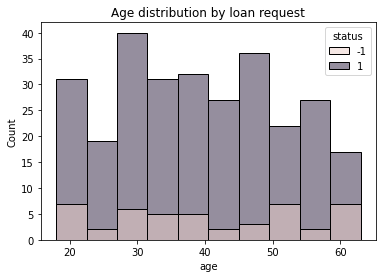

In [1289]:
sb.histplot(data=loan_train_df, x="age", hue="status").set(title="Age distribution by loan request");

### Correlation matrix

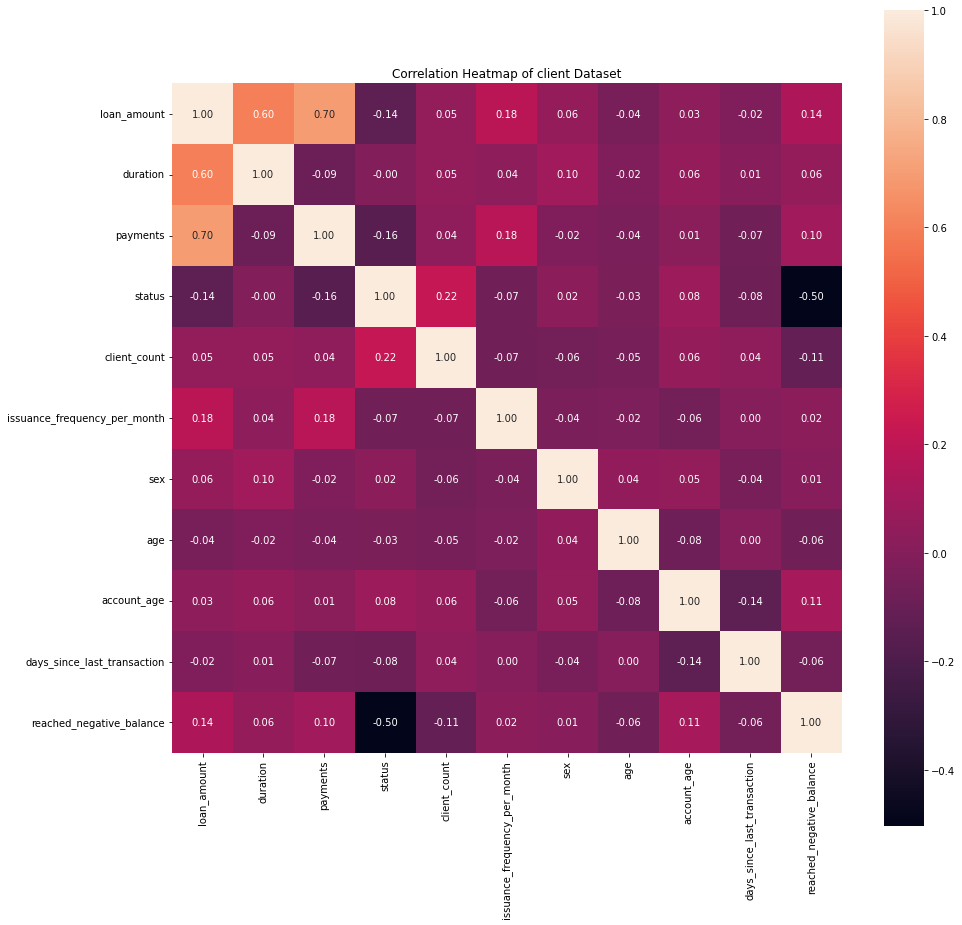

In [1290]:
corr_matrix = loan_train_df.drop("loan_id", axis=1).corr(method='spearman')

plt.figure(figsize=(15,15))
plt.title('Correlation Heatmap of client Dataset')

sb.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black')

plt.show()

## Export preprocessed dataframes

In [1291]:
loan_train_df.to_pickle("../out/train.pkl")
loan_test_df.to_pickle("../out/test.pkl")